# Blood Stain Identification using 3D CNN
Blood Stain Detection in a non destructive manner while keeping the evidence as it is, is an important field in forensic sciences. Hyperspecteral Images can be used to Identify Blood. For that The Authors of [1] used several techniques and the 3D CNN performed best and showed great success. In this notebook, We've implemented the architecture they proposed for 3D CNN and presented the results. We have done
- Tiling of data
- Principal Component Analysis for Dimension Reduction
- SMOTE for balancing the data
- Normalization of Data
- Model Training
- Model Prediction
- Classification Report

## Import Required Libraries

In [ ]:
# Colab Requirements
!pip install spectral
import spectral
from google.colab import drive, files
#drive.mount('/content/drive')

## Basics
import gc
gc.collect()

import time
import numpy as np
import pandas as pd

#from PIL import Image
from operator import truediv

import scipy.io as sio
import os
import seaborn as sns


## Ploting
#from plotly.offline import iplot, init_notebook_mode
#import plotly.graph_objs as go
#from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
#init_notebook_mode(connected=True)
%matplotlib inline


## Sklearn
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score


## Dimensionality Reduction Methods
from sklearn.decomposition import PCA

## Deep Model
import keras, h5py
from keras.layers import Input, Conv2D, Conv3D, Flatten, Dense, Reshape, Dropout


#Tensorflow
import tensorflow as tf

#from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
import spectral.io.envi as envi


# SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load Dataset
Using HyperBlood API
Basic loader for dataset files

Warning:
- By default, data is cleared by removing noisy bands and broken line in the image.
- Note that the 'F(2k)' image was captured with different camera. Its bands were interpolated to match remaining images. However, due to spectral range differences between cameras, it has less bands. After cleaning (default) all images have the same matching 113 bands.

- NOISY_BANDS_INDICES = np.array([0,1,2,3,4,48,49,50,121,122,123,124,125,126,127])

In [ ]:
#IMAGES = ['A(1)','B(1)','C(1)','D(1)','E(1)','E(7)','E(21)','F(1)','F(1a)','F(1s)','F(2)','F(2k)','F(7)','F(21)']
IMAGES = ['E(1)']


#change this to your DS location
PATH_DATA = '/content/drive/MyDrive/Computer Vision/hyperblood/'


In [ ]:
def get_data(name,remove_bands=True,clean=True):
    """
    Returns HSI data from a datacube

    Parameters:
    ---------------------
    name: name
    remove_bands: if True, noisy bands are removed (leaving 113 bands)
    clean: if True, remove damaged line

    Returns:
    -----------------------
    data, wavelenghts as numpy arrays (float32)
    """
    name = convert_name(name)
    filename = "{}data/{}".format(PATH_DATA,name)
    hsimage = envi.open('{}.hdr'.format(filename),'{}.float'.format(filename))
    wavs = np.asarray(hsimage.bands.centers)
    data = np.asarray(hsimage[:,:,:],dtype=np.float32)

    #removal of damaged sensor line
    if clean and name!='F_2k':
        data = np.delete(data,445,0)


    if not remove_bands:
        return data,wavs
    return data[:,:,get_good_indices(name)],wavs[get_good_indices(name)]

In [ ]:
def get_anno(name,remove_uncertain_blood=True,clean=True):
    """
    Returns annotation (GT) for data files as 2D int numpy array
    Classes:
    0 - background
    1 - blood
    2 - ketchup
    3 - artificial blood
    4 - beetroot juice
    5 - poster paint
    6 - tomato concentrate
    7 - acrtylic paint
    8 - uncertain blood

    Parameters:
    ---------------------
    name: name
    clean: if True, remove damaged line
    remove_uncertain_blood: if True, removes class 8

    Returns:
    -----------------------
    annotation as numpy 2D array
    """
    name = convert_name(name)
    filename = "{}anno/{}".format(PATH_DATA,name)
    anno = np.load(filename+'.npz')['gt']
    #removal of damaged sensor line
    if clean and name!='F_2k':
        anno = np.delete(anno,445,0)
    #remove uncertain blood + technical classes
    if remove_uncertain_blood:
        anno[anno>7]=0
    else:
        anno[anno>8]=0

    return anno

Utility Functions

In [ ]:

def get_good_indices(name=None):
    """
    Returns indices of bands which are not noisy

    Parameters:
    ---------------------
    name: name
    Returns:
    -----------------------
    numpy array of good indices
    """
    name = convert_name(name)
    if name!='F_2k':
        indices = np.arange(128)
        indices = indices[5:-7]
    else:
        indices = np.arange(116)
    indices=np.delete(indices,[43,44,45])
    return indices

In [ ]:
def convert_name(name):
    """
    Ensures that the name is in the filename format
    Parameters:
    ---------------------
    name: name

    Returns:
    -----------------------
    cleaned name
    """
    name = name.replace('(','_')
    name = name.replace(')','')
    return name

In [ ]:
def get_rgb(data,wavelengths,gamma=0.7,vnir_bands=[600, 550, 450]):
    """
   returns an (over)simplified RGB visualization of HSI data

    Parameters:
    ---------------------
    data: data cube as nparray
    annotation: wavelengths - band wavelenghts
    gamma: gamma correction value
    vnir_bands: bands used for RGB

    Returns:
    -----------------------
    rgb image as numpy array
    """
    assert data.shape[2]==len(wavelengths)
    max_data = np.max(data)
    rgb_i = [np.argmin(np.abs(wavelengths - b)) for b in vnir_bands]
    ret = data[:,:,rgb_i].copy()/max_data

    if gamma!=1.0:
        for i in range(3):
            ret[:,:,i]=np.power(ret[:,:,i],gamma)

    return ret

In [ ]:
def get_Xy(data,anno):
    """
    return data as 2D arrays (useful e.g. for applying sklearn functions)

    Parameters:
    ---------------------
    data: data cube as nparray
    annotation: 2d annotation array

    Returns:
    -----------------------
    X: 2d array (no. pixels x no.bands)
    y: labels for pixels
    """
    X = data.reshape(-1,data.shape[2])
    y = anno.reshape(-1)
    return X,y

## Tile Images

In [ ]:
# Function to perform tiling on masks provided
def tile(img, size, overlap=0.5):
    """
    Function to tile an input image into overlapping tiles
    """
    tiles = []
    if len(img.shape) == 2:
      height, width = img.shape
    elif len(img.shape) == 3:
       height, width, channel = img.shape
    tile_h, tile_w = size[:2]
    offset_h = int(tile_h * overlap)
    offset_w = int(tile_w * overlap)
    for i in range(0, height- tile_h + 1, offset_h):
        for j in range(0, width - tile_w + 1, offset_w):
            if len(img.shape) == 2:
                tiles.append(img[i:i+tile_h, j:j+tile_w])
            elif len(img.shape) == 3:
                tiles.append(img[i:i+tile_h, j:j+tile_w, :])
    return tiles

In [ ]:
# Function to perform tiling on masks provided
def tile_anno(img, size, overlap=0.5):
    """
    Function to tile an input image into overlapping tiles
    """
    labels = []
    if len(img.shape) == 2:
      height, width = img.shape
    elif len(img.shape) == 3:
       height, width, channel = img.shape
    tile_h, tile_w = size[:2]
    offset_h = int(tile_h * overlap)
    offset_w = int(tile_w * overlap)
    for i in range(0, height- tile_h + 1, offset_h):
        for j in range(0, width - tile_w + 1, offset_w):
            # Calculate the bincount of the tile
            bin_counts = np.bincount(img[i:i+tile_h, j:j+tile_w].flatten())
            # Find the class with maximum occurrence
            max_class = np.argmax(bin_counts)
            # Append the maximum occurring class to the labels array
            labels.append(max_class)
    return labels

In [ ]:
# name = 'F(21)'
# data, wav = get_data(name)
# anno = get_anno(name)
# img = get_rgb(data,wav)

In [ ]:
# tiles_data = tile(data, (112,224))
# tiles_anno = tile(anno, (112,224))
# rgb_tiles_data = []
# for i in range(np.shape(tiles_data)[0]):
#   rgb_tiles_data.append(get_rgb(tiles_data[i], wav))

In [ ]:
# print(np.shape(tiles_data))
# print(np.shape(tiles_anno))

(40, 112, 224, 113)
(40, 112, 224)


## LOAD COMPLETE DATASET

In [ ]:
HSI_data = []
HSI_wav = []
HSI_anno = []
for img in IMAGES:
  data, wav = get_data(img)
  HSI_data.append(data)
  HSI_wav.append(wav)
  HSI_anno.append(get_anno(img))
  print(f"The image named {img} successfully loaded")

The image named E(1) successfully loaded


In [ ]:
print("HSI_data ", np.shape(HSI_data))
print("HSI_anno ", np.shape(HSI_anno))
print("HSI_wav ", np.shape(HSI_wav))

HSI_data  (1, 519, 696, 113)
HSI_anno  (1, 519, 696)
HSI_wav  (1, 113)


## Apply Principal Component Analysis for Dimension Reduction

In [ ]:
#conversion of 3D data into 2D data
reshaped_data = []
reshaped_anno = []
for i in range(len(IMAGES)):
  rs_data, rs_anno = get_Xy(HSI_data[i], HSI_anno[i])
  reshaped_data.append(rs_data)
  reshaped_anno.append(rs_anno)

In [ ]:
print("reshaped_data ", np.shape(reshaped_data))
print("reshaped_anno ", np.shape(reshaped_anno))

reshaped_data  (1, 361224, 113)
reshaped_anno  (1, 361224)


In [ ]:
# Combine separate arrays into a single 3D array
combined_data = np.concatenate(reshaped_data, axis=0)  # Shape: (14 * 361224, 113)
combined_labels = np.concatenate(reshaped_anno, axis=0)  # Shape: (14 * 361224,)

In [ ]:
print("combined_data ", np.shape(combined_data))
print("combined_labels ", np.shape(combined_labels))

combined_data  (361224, 113)
combined_labels  (361224,)


In [ ]:
# In case if you want to utilize GPU, You can uncomment the following line to set TensorFlow to utilize the GPU
#tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

# Perform PCA
pca = PCA(n_components=25)  #As done in refferenced code

# Convert the data to TensorFlow variables for GPU acceleration
combined_data = tf.Variable(combined_data)
combined_labels = tf.Variable(combined_labels)

# To Run PCA on GPU
#with tf.device('/GPU:0'):
pca.fit(combined_data)

# Apply PCA transformation to the data
#with tf.device('/GPU:0'):
transformed_data = pca.transform(combined_data)  # Shape: (14 * 361224, n_components)

print(np.shape(transformed_data))

(361224, 25)


In [ ]:
print("data: " , np.shape(transformed_data))
print("labels: ", np.shape(combined_labels))

data:  (361224, 25)
labels:  (361224,)


In [ ]:
transformed_data = np.reshape(transformed_data, (519, 696, 25))
combined_labels = np.reshape(combined_labels, (519, 696))
print("data: " , np.shape(transformed_data))
print("labels: ", np.shape(combined_labels))

data:  (519, 696, 25)
labels:  (519, 696)


## Perform Tiling with Overlap
We created tiles for ease of computation because of limited memory resources, it was near to impossible to evaluate the complete Hyperspecteral Images, even after dimension reduction through PCA.

In [ ]:
tiles_data = np.array(tile(transformed_data, (9,9),1))
tiles_anno = np.array(tile_anno(combined_labels, (9,9),1))

In [ ]:
print("tiled data: ", np.shape(tiles_data))
print("tiled anno: ", np.shape(tiles_anno))

tiled data:  (4389, 9, 9, 25)
tiled anno:  (4389,)


## Perform Oversampling of Data using SMOTE
as the data is skewed towards background, It is important to balance the dataset using advanced techniques such as synthetic minority oversampling technique (SMOTE), which generates synthetic samples to balance the dataset while minimizing redundancy.

In [ ]:
from imblearn.over_sampling import SMOTE

# Assuming your dataset is stored in a numpy array called 'data' with shape (4389, 9, 9, 25)
# Reshape the data to a 2D array for SMOTE
reshaped_data = tiles_data.reshape(-1, 9*9*25)

# Assuming the labels are stored in a numpy array called 'labels'
# Convert the labels to a 1D array
labels = tiles_anno.flatten()

# Instantiate the SMOTE object
smote = SMOTE()

# Apply SMOTE to oversample the minority class
oversampled_data, oversampled_labels = smote.fit_resample(reshaped_data, labels)

# Reshape the oversampled data back to its original shape
oversampled_data = oversampled_data.reshape(-1, 9, 9, 25)

# Check the shape of the oversampled data and labels
print(oversampled_data.shape)
print(oversampled_labels.shape)

(27951, 9, 9, 25)
(27951,)


In [ ]:
oversampled_labels = np_utils.to_categorical(oversampled_labels)

In [ ]:
print("tiled and oversampled data: ", np.shape(oversampled_data))
print("tiled and oversampled anno: ", np.shape(oversampled_labels))

tiled and oversampled data:  (27951, 9, 9, 25)
tiled and oversampled anno:  (27951, 8)


## Perform Train Test Split

In [ ]:
# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(oversampled_data, oversampled_labels, test_size=0.2, random_state=42)

# Reshape the data
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension
X_test = np.expand_dims(X_test, axis=-1)

## Normalize the Data

In [ ]:
# Normalize the data (example using min-max scaling)
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_train.min()) / (X_train.max() - X_train.min())

## Build Model
Model selection for this task was the most cruicial part We've read several Research Papers and implemented the 3D Graph Convolutional Neural Network Suggested by [Blood Stain Classification with Hyperspectral Imaging and Deep Neural Networks [1]](https://www.mdpi.com/1424-8220/20/22/6666) which was originaly proposed in another paper as *6 Layer architecture* in [Three Dimensional Deep Learning Approach For Remote Sensing Image Classification [2]](https://arxiv.org/pdf/1806.05824.pdf) as shown in the figure below:


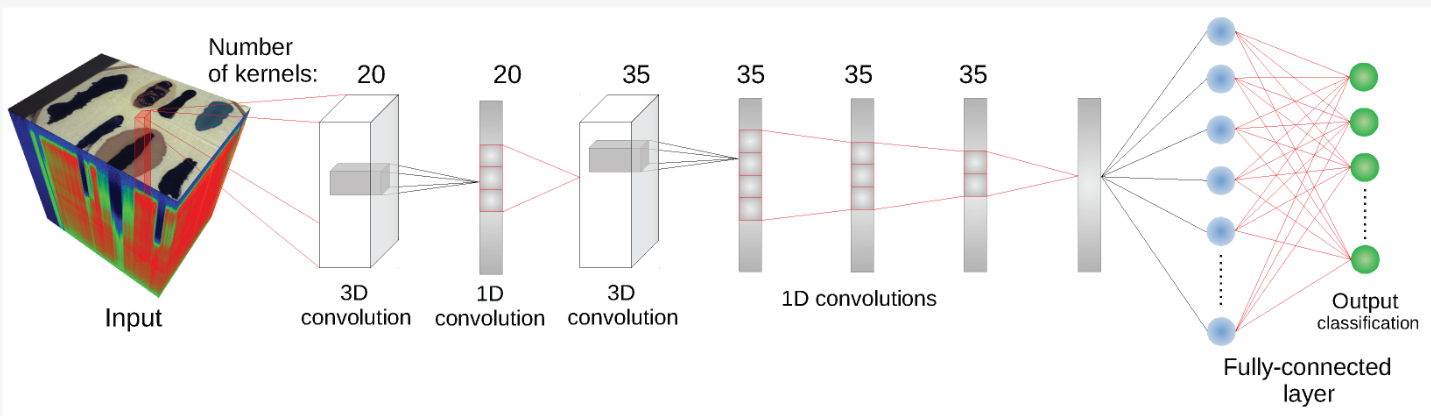

The hyperparameters choosed for the model are also very similar to ones selected by the authores of [[2]](https://arxiv.org/pdf/1806.05824.pdf)

In [ ]:
num_classes = max(np.unique(HSI_anno))+1

In [ ]:
num_classes

8

In [ ]:
model = tf.keras.Sequential([
tf.keras.layers.Conv3D(filters=20, kernel_size=(3, 3, 3), strides=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], 1), kernel_initializer='he_uniform'),
tf.keras.layers.Conv1D(filters=20, kernel_size=(3), strides=2, kernel_initializer='he_uniform'),
tf.keras.layers.Conv3D(filters=35, kernel_size=(3, 3, 3), strides=1, activation='relu', kernel_initializer='he_uniform'),
tf.keras.layers.Conv1D(filters=35, kernel_size=(3), strides=2, kernel_initializer='he_uniform'),
tf.keras.layers.Conv1D(filters=35, kernel_size=(3), strides=1, activation='relu', kernel_initializer='he_uniform'),
tf.keras.layers.Conv1D(filters=35, kernel_size=(2), strides=2, activation='relu', kernel_initializer='he_uniform'),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer='he_uniform')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
# Create the learning rate scheduler callback

#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
# Compile the model with the initial learning rate
#initial_learning_rate = 0.001
#model.compile(loss='categorical_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=initial_learning_rate), metrics=['accuracy'])
#print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 7, 7, 23, 20)      560       
                                                                 
 conv1d (Conv1D)             (None, 7, 7, 11, 20)      1220      
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 5, 9, 35)       18935     
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 5, 4, 35)       3710      
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 5, 2, 35)       3710      
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 5, 1, 35)       2485      
                                                                 
 flatten (Flatten)           (None, 875)               0

## Model Training

In [ ]:
# Train the model
y_train = np.array(y_train)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
699/699 [==============================] - 22s 9ms/step - loss: 0.7952 - accuracy: 0.6857 - val_loss: 2.9975 - val_accuracy: 0.5845
Epoch 2/10
699/699 [==============================] - 5s 7ms/step - loss: 0.1138 - accuracy: 0.9651 - val_loss: 5.8398 - val_accuracy: 0.5985
Epoch 3/10
699/699 [==============================] - 6s 9ms/step - loss: 0.0538 - accuracy: 0.9847 - val_loss: 10.0613 - val_accuracy: 0.5537
Epoch 4/10
699/699 [==============================] - 5s 7ms/step - loss: 0.0310 - accuracy: 0.9913 - val_loss: 8.8899 - val_accuracy: 0.5337
Epoch 5/10
699/699 [==============================] - 6s 8ms/step - loss: 0.0234 - accuracy: 0.9933 - val_loss: 9.1949 - val_accuracy: 0.6124
Epoch 6/10
699/699 [==============================] - 6s 8ms/step - loss: 0.0237 - accuracy: 0.9931 - val_loss: 10.5792 - val_accuracy: 0.6734
Epoch 7/10
699/699 [==============================] - 5s 7ms/step - loss: 0.0116 - accuracy: 0.9969 - val_loss: 5.9119 - val_accuracy: 0.7378
Epo

## Make Predictions

In [ ]:
pred = model.predict(X_test)

175/175 [==============================] - 1s 2ms/step


## Plot Predictions & Classificatiion Reports

In [ ]:
predicted_labels = np.argmax(pred, axis=1)

In [ ]:
true_labels = np.argmax(y_test, axis=1)

In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.38      0.91      0.53       793
           1       0.99      0.40      0.57       813
           2       1.00      0.96      0.98       812
           3       0.75      0.49      0.59       809
           5       0.99      0.99      0.99       798
           6       0.99      0.47      0.64       798
           7       0.89      1.00      0.94       768

    accuracy                           0.74      5591
   macro avg       0.86      0.75      0.75      5591
weighted avg       0.86      0.74      0.75      5591



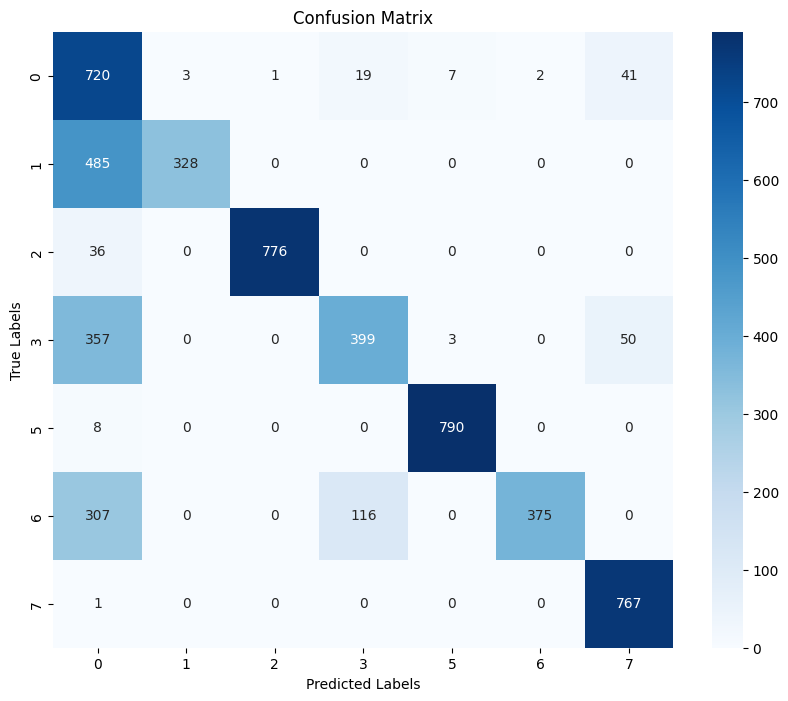

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique(HSI_anno), yticklabels=np.unique(HSI_anno))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# model = tf.keras.Sequential([
# tf.keras.layers.Conv3D(filters=20, kernel_size=(3, 3, 3), strides=1, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],25,1), kernel_initializer='he_uniform'),
# tf.keras.layers.Conv1D(filters=20, kernel_size=(3), strides=2, kernel_initializer='he_uniform'),
# tf.keras.layers.Conv3D(filters=35, kernel_size=(3, 3, 3), strides=1, activation='relu', kernel_initializer='he_uniform'),
# tf.keras.layers.Conv1D(filters=35, kernel_size=(3), strides=2, kernel_initializer='he_uniform'),
# tf.keras.layers.Conv1D(filters=35, kernel_size=(3), strides=1, activation='relu', kernel_initializer='he_uniform'),
# tf.keras.layers.Conv1D(filters=35, kernel_size=(2), strides=2, activation='relu', kernel_initializer='he_uniform'),
# tf.keras.layers.Flatten(),
# tf.keras.layers.Dense(units=8, activation='softmax', kernel_initializer='he_uniform')
# ])

# input_layer = Input((X_train.shape[1], X_train.shape[2], X_train.shape[3], 1))
# conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
# conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), strides=2, activation='relu')(conv_layer1)
# conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), strides=3, activation='relu')(conv_layer2)
# flatten_layer = Flatten()(conv_layer3)
# dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
# dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
# output_layer = Dense(units = 8, activation='softmax')(dense_layer2)
# model = Model(inputs=input_layer, outputs=output_layer)


In [ ]:
# model = tf.keras.Sequential([
# tf.keras.layers.Conv3D(filters=20, kernel_size=(3, 3, 3), strides=1, activation='relu', input_shape=(9,9,25,1), kernel_initializer='he_uniform'),
# tf.keras.layers.Conv1D(filters=20, kernel_size=(3), strides=2, kernel_initializer='he_uniform'),
# tf.keras.layers.Conv3D(filters=35, kernel_size=(3, 3, 3), strides=1, activation='relu', kernel_initializer='he_uniform'),
# tf.keras.layers.Conv1D(filters=35, kernel_size=(3), strides=2, kernel_initializer='he_uniform'),
# tf.keras.layers.Conv1D(filters=35, kernel_size=(3), strides=1, activation='relu', kernel_initializer='he_uniform'),
# tf.keras.layers.Conv1D(filters=35, kernel_size=(2), strides=2, activation='relu', kernel_initializer='he_uniform'),
# tf.keras.layers.Flatten(),
# tf.keras.layers.Dense(units=8, activation='softmax', kernel_initializer='he_uniform')
# ])

## Plot the Images and their Tiles

In [ ]:
rgb_data = get_rgb(HSI_data[0], wav)
print(rgb_data.shape)

(519, 696, 3)


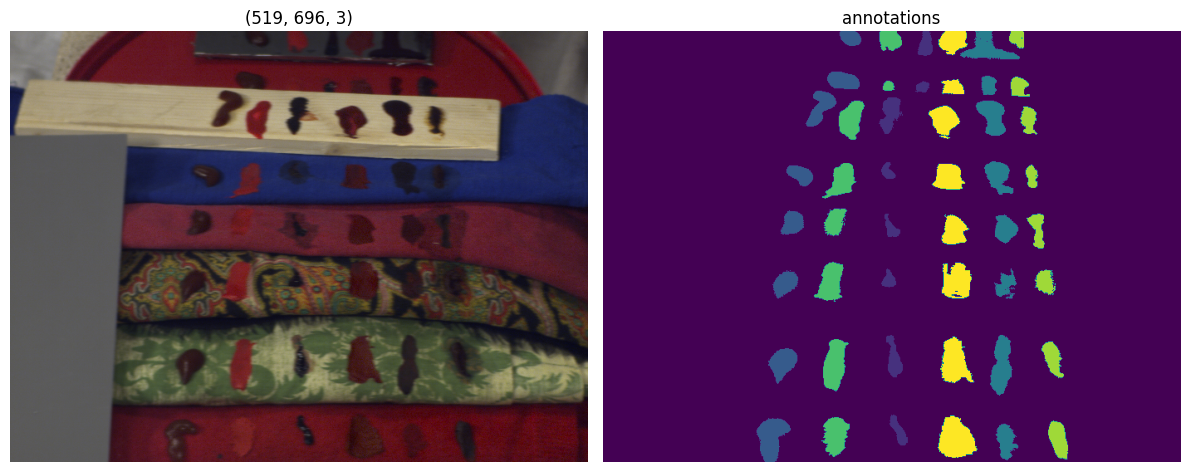

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(rgb_data)
axs[0].axis('off')
axs[0].set_title(rgb_data.shape)

axs[1].imshow(HSI_anno[0])
axs[1].axis('off')
axs[1].set_title("annotations")

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [ ]:
rgb_tiles = tile(rgb_data, (9,9), 1)
print(np.shape(rgb_tiles))

(4389, 9, 9, 3)


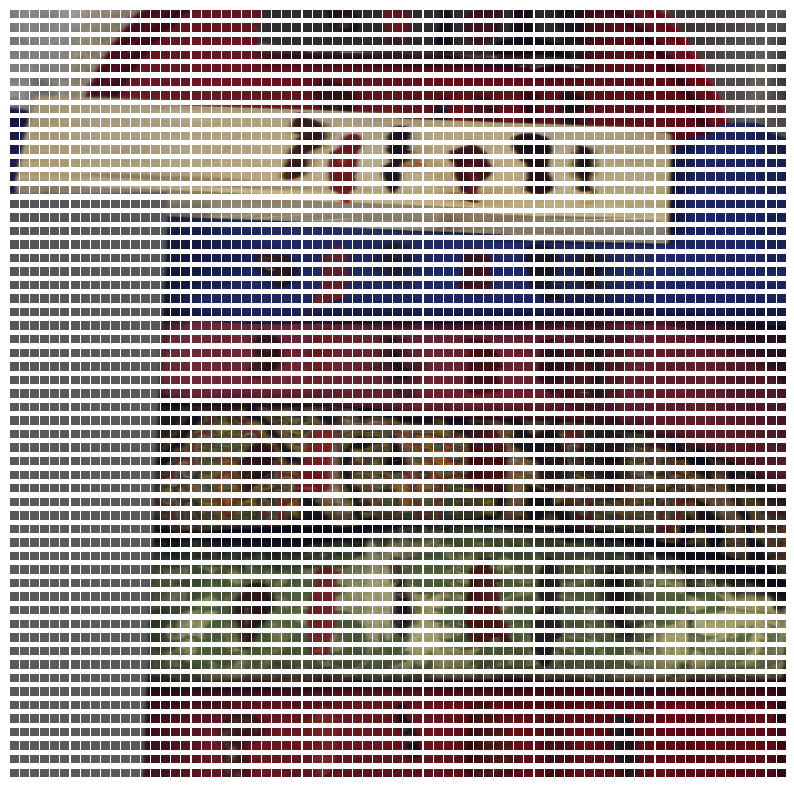

In [ ]:
# Define the size of the grid
num_rows = 57
num_cols = 77

# Create a figure and axis object
fig, ax = plt.subplots(num_rows, num_cols, figsize=(10,10))

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# Flatten the axis object for easy indexing
ax = ax.flatten()

# Loop through the images and plot them
for i in range(num_rows * num_cols):
    ax[i].imshow(rgb_tiles[i])
    ax[i].axis('off')

# Hide the remaining empty subplots
for j in range(num_rows * num_cols, len(ax)):
    ax[j].axis('off')

# Display the plot
plt.show()
